# Getting Started with models

This notebook introduces you to the modelling features of BatchFlow library via creating a simple regression model.

In [1]:
import sys

# the following line is not required if BatchFlow is installed as a python package.
sys.path.append('../..')

import numpy as np
import tensorflow as tf
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

from batchflow.models.tf import TFModel
from batchflow.models.torch import TorchModel
from batchflow import Dataset, C, V, F, B, action, Batch
from batchflow.models.metrics import ClassificationMetrics

plt.style.use('seaborn-poster')
plt.style.use('ggplot')

## Define a batch class

Creating a specific batch class is not required, though convenient. Besides, here it helps you get an idea of what batch components are.

In [2]:
class MyBatch(Batch):
    """ Batch class for regression models """
    components = 'features', 'labels'

All the batches will have 2 components: features and labels. Batch components might be thought of as columns in a table, while batch items are rows.

## Linear regression
Firstly, we consider a linear regression that allows solving tasks where targets are continuous variables.

For this reason we generate data from uniform or normal distributions, multiply it by normally distributed weights and add normally distributed noise and then try to predict it. 

In [3]:
def generate_linear_data(size, dist='unif', shape=13):
    """ Generation of data to fit linear regression.

    Parameters
    ----------
    size: int
        data length

    dist: {'unif', 'norm'}
        sample distribution 'unif' or 'norm'. Default is 'unif'
    
    shape: int
        a length of a feature vector

    Returns
    -------
    x: numpy array
        Uniformly or normally distributed array

    y: numpy array
        array with some random noize
    """
    if dist == 'unif':
        x = np.random.uniform(0, 2, size=(size, shape))
    elif dist == 'norm':
        x = np.random.normal(size=(size, shape))

    w = np.random.normal(loc=1., size=(shape, 1))
    error = np.random.normal(loc=0., scale=0.1, size=(size, 1))

    y = np.dot(x, w) + error

    return x, y

In this case, `x` and `y` are numpy arrays:
- `x` is a matrix with __size__ rows and 13 columns
- `y` is a vector of __size__ items.

In [4]:
size = 1000
linear_x, linear_y = generate_linear_data(size)

### Create a dataset

Now it's time to create a dataset (an instance of Dataset class) which generates batches of __MyBatch__ class. 

Even though the dataset does not have any data yet, it contains the full index of dataset items. So we can split it into __train__ and __test__ parts.

In [5]:
linear_dset = Dataset(size, batch_class=MyBatch)
linear_dset.split()

After creation the dataset is empty, until data is loaded with [a pipeline](https://analysiscenter.github.io/batchflow/intro/pipeline.html) which allows you to use and perform action-methods from the [batch class](https://analysiscenter.github.io/batchflow/intro/batch.html).

In [6]:
pipeline = (linear_dset.train.p
                       .load(src=(linear_x, linear_y)))

### Define a model

The pipeline above only loads data. Clearly, it doesn't train a linear regression, therefore it is not enough for us.   
Hence, we need to create a linear regression model.   
1.    One way to do this is to write your own class.   
In case of TF models you need to inherit from [TFModel](https://analysiscenter.github.io/batchflow/api/batchflow.models.tf.base.html#batchflow.models.tf.base.TFModel) base class, in case Pytorch models - [TorchModel](https://analysiscenter.github.io/batchflow/api/batchflow.models.torch.base.html#batchflow.models.torch.base.TorchModel)      
Define `initial_block`, `body` or `head` methods, which are the parts your model consist of, inside your class.

Here is an example of linear model for Tensorflow.

```
class TFLinearModel(TFModel):
    @classmethod
    def body(cls, inputs, units, name='body', **kwargs):
        with tf.variable_scope(name):
            return tf.layers.dense(inputs, units=units, name='dense')
```

And Torch.

```
class TorchLinearModel(TorchModel):
    @classmethod
    def body(cls, inputs, units, **kwargs):
        in_features = np.prod(inputs.shape[1:])
        return nn.Linear(in_features, units)
```

For more details on how to create your own model see [tf](https://analysiscenter.github.io/batchflow/intro/tf_models#how-to-write-a-custom-model) and [torch](https://analysiscenter.github.io/batchflow/intro/torch_models.html#how-to-write-a-custom-model) documentation.

2. Another way to do this is to declare your model through the [config](https://analysiscenter.github.io/batchflow/intro/torch_models.html#how-to-configure-a-model). 

Batchflow provides you with simple and convinient interface for creating deep neural networks with just a few lines of code.   
The configs for the same TF and Torch models are identical.   

First of all model config should contain __inputs__ sections for input tensors (placeholders) parameters:
- shape
- tensor's name
- typical transformations (like one-hot-encoding)
and so on.

To configure 'inputs' use the __inputs_config__ dict shown in the cell below. This dict has two keys:
* __features__ - the name of the placeholder for the input data.
* __labels__ - the name of the placeholder for the answers before all transformations.

Values for these keys are dicts themselves which describe `features` and `labels` placeholders.

In [7]:
inputs_config = {
    'features/shape': B.features.shape[1:],
    'labels/shape': B.labels.shape[1:]
}

Letter B in _values_ is a [named expression](https://analysiscenter.github.io/batchflow/intro/named_expr.html) which replaces the name within it into a value from a batch class attribute or a component.   
In this case, it is the [component](https://analysiscenter.github.io/batchflow/intro/batch.html#components) name defined in the batch class.  

Define the model config.

In [8]:
model_config = {
    'inputs': inputs_config,
    'initial_block/inputs': 'features',
    'body/layout': 'f',
    'body/units': 1,
    'loss': 'mse',
    'optimizer': 'Adam',
}

config keys:
* __inputs__ - input data configuration (described above).
* __initial_block/inputs__ - the name of input tensor which should be fed into the model.
* __body/layout__ - the sequence of layers in the body of your network. `f` stands for the single fully connected layer.
* __body/units__ - number of neurons in fully-connected layers. Can be a _list_, if you have more than one dense layer.
* __loss__ - a loss function to optimize.
* __optimizer__ - an optimization algorithm and its parameters.

As you can see, some configuration options have a hierarchical structure.

After the model is ready, you need to train it. The pipeline allows you to do this with just two functions:
* [__init_model__](https://analysiscenter.github.io/batchflow/api/batchflow.pipeline.html?highlight=init_model#batchflow.Pipeline.init_model) allows to initialize the model with given config.
* [__train_model__](https://analysiscenter.github.io/batchflow/api/batchflow.pipeline.html?highlight=train_model#batchflow.Pipeline.train_model) [fits a model with training data](https://analysiscenter.github.io/batchflow/intro/models.html#training-a-model).

### Training pipeline

Now let's create a pipeline, which can generate batches and train a model.

Remind that you can train TF or Torch models with the same interface.

In [9]:
pipeline_config = {
    'model': TFModel 
}

In [10]:
pipeline_config = {
    'model': TorchModel
}

In this example we exploit Torch models. Just link the pipeline config above with the model to the pipeline itself.   

In [11]:
BATCH_SIZE = 100
train_linear = (linear_dset.train.pipeline(pipeline_config) 
                .load(src=(linear_x, linear_y))
                .init_variable('loss', [])
                .init_model('dynamic',
                            C('model'),
                            name='linear',
                            config=model_config)
                .train_model('linear', 
                             features=B('features'),
                             labels=B('labels'),
                             fetches='loss',
                             save_to=V('loss', mode='a'))
                .run_later(BATCH_SIZE, shuffle=True, n_epochs=300, bar=True))

In [12]:
train_linear.run()

100%|██████████| 2400/2400 [00:12<00:00, 189.24it/s]


Plot the loss function.

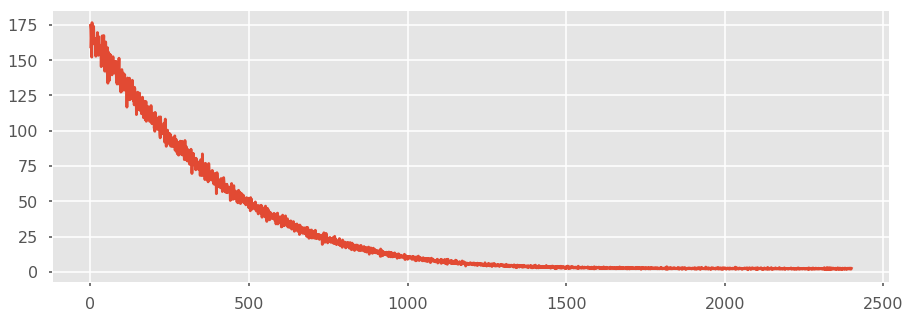

In [13]:
loss = train_linear.v('loss')
plt.figure(figsize=(15, 5))
plt.plot(loss)
plt.show()

### Validation pipeline

A prediction pipeline would be also helpful. For this purpose the method [__predict_model__](https://analysiscenter.github.io/batchflow/intro/models.html#predicting-with-a-model) is used. 

I would direct your attention to the argument named __fetches__.
It returns a value of tensor with a specified name. Using it, you can always get from model any tensor you want.

As you might already know, in __output__ configuration parameter (when calling __init_model__) you can specify a list of useful outputs, such as 'proba', 'sigmoid', etc. (if you don't know about it, read [the documentation](https://analysiscenter.github.io/batchflow/intro/tf_models#output)). And __predict_model__'s __fetches__ argument allows to get those outputs from a model.

Another important method is [__import_model__](https://analysiscenter.github.io/batchflow/intro/models.html#importing-models) that loads a model from another pipeline.

In [14]:
test_linear = (linear_dset.test.p
                 .load(src=(linear_x, linear_y))
                 .import_model('linear', train_linear)
                 .init_variable('predict', [])
                 .predict_model('linear',
                                fetches='predictions',
                                features=B('features'),    
                                targets=B('labels'),
                                save_to=V('predict', mode='a'))
                 .run(BATCH_SIZE, shuffle=False, n_epochs=1, bar=True))

100%|██████████| 2/2 [00:00<00:00, 315.93it/s]


In the last __pipeline__, we test our model. Let's see, how well does it work?

In [15]:
predict = np.array(test_linear.get_variable('predict')).reshape(-1, 1)
target = np.array(linear_y[linear_dset.test.indices])

error = np.mean(np.abs((target - predict) * 100 / target))

print('Average error: {}%'.format(round(error, 3)))

Average error: 10.314%


The accuracy is far from being perfect because the training was too short (in order not make you wait too long). Increase the number of epochs in the training pipeline up to 1000 to get a more accurate predictions.

# Logistic regression 
It solves a task with a binary target (0 or 1, -1 or 1 and etc).

To train a logistic regression we generate two-dimensional data from two linearly separable clusters and fit a model to predict a cluster for a given point.

In [16]:
def generate_logistic_data(size, first_params, second_params):
    """ Generation of data for fit logistic regression.
    Parameters
    ----------
    size: int
        number of data items

    first_params: list of list
        distribution params for cloud #0

    second_params: list of list
        distribution params for cloud #1

    Returns
    -------
    x: numpy array
        coordinates in two-dimensional space

    y: numpy array
        labels {0, 1}
    """
    first = np.random.multivariate_normal(first_params[0], first_params[1], size)
    second = np.random.multivariate_normal(second_params[0], second_params[1], size)

    x = np.vstack((first, second))
    y = np.hstack((np.zeros(size), np.ones(size)))
    shuffle = np.arange(len(x))
    np.random.shuffle(shuffle)
    x = x[shuffle]
    y = y[shuffle] #.reshape(-1, 1)

    return x, y

In [17]:
size = 500
logistic_x, logistic_y = generate_logistic_data(size, [[1,2],[[15,0],[0,15]]], [[10,17],[[15,0],[0,15]]])

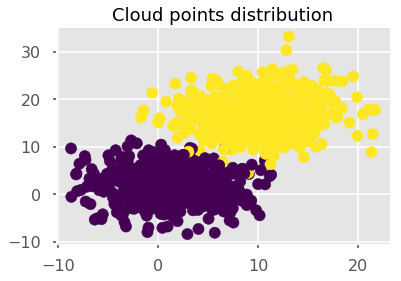

In [18]:
plt.scatter(logistic_x[:,0], logistic_x[:,1], c=logistic_y)
plt.title('Cloud points distribution', fontsize=18)
plt.show()

One of the most important things that you need to know is that it really doesn't matter which model you want to train and what data you will use for it. The procedure stays the same.

First of all, a dataset is created and split into train/test parts.

In [19]:
logistic_dset = Dataset(size, batch_class=MyBatch)
logistic_dset.split()

As you can see, the pipeline and configurations also does not change much:

- labels __classes__ - the number of classes. We have a binary classification, hence 2 classes. 

In [20]:
inputs_config = {
    'features/shape': B.features.shape[1:],
    'labels/classes': 2
}

Model configuration for logistic regression. The difference is that now we need 2 output neurons(one for each class) and [CrossEntropy loss](https://en.wikipedia.org/wiki/Cross_entropy#Cross-entropy_loss_function_and_logistic_regression).

In [21]:
model_config = {
    'inputs': inputs_config,
    'initial_block/inputs': 'features',
    'body': {'layout': 'f', 'units': 2},
    'loss': 'ce',
    'optimizer': 'Adam',
}

Let's create and execute the pipeline with __run__:

In [22]:
BATCH_SIZE = 100

train_logistic = (logistic_dset.train.pipeline(pipeline_config)
                .load(src=(logistic_x, logistic_y))
                .init_variable('loss', [])
                .init_model('dynamic',
                            C('model'),
                            'logistic',
                            config=model_config)
                .train_model('logistic',
                             fetches='loss',
                             features=B('features'),
                             labels=B('labels'),
                            save_to=V('loss', mode='a'))
                .run(BATCH_SIZE, shuffle=True, n_epochs=100))

Plot the loss function.

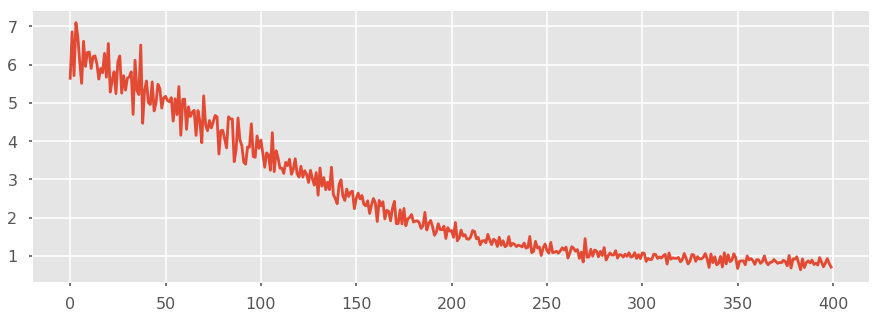

In [23]:
loss = train_logistic.v('loss')
plt.figure(figsize=(15, 5))
plt.plot(loss)
plt.show()

In the same way, create test pipeline and run it too

In [24]:
test_logistic = (logistic_dset.test.p
                .import_model('logistic', train_logistic)
                .load(src=(logistic_x, logistic_y))
                .init_variables(['predictions', 'metrics'])
                .predict_model('logistic', 
                             fetches='predictions' ,
                             features=B('features'),
                             targets=B('labels'),
                             save_to=V('predictions'))
                .gather_metrics(ClassificationMetrics, targets=B('labels'), predictions=V('predictions'),
                                fmt='logits', axis=-1, save_to=V('metrics', mode='a'))
                .run(BATCH_SIZE, shuffle=False, n_epochs=1))

After measure the quality of training

In [25]:
accuracy = test_logistic.get_variable('metrics').evaluate('accuracy')
print('Percentage of accurate predictions: {:.2%}'.format(accuracy))

Percentage of accurate predictions: 58.00%


And again to imporove the accuracy increase the number of epochs in the training pipeline.

# Poisson regression 
[Poisson regression](https://en.wikipedia.org/wiki/Poisson_regression) is being used if the answers contain counts. 

The example shows how we can train poisson regression by using data generated from poisson distribution.

In [26]:
def generate_poisson_data(lam, size=10, shape=13):
    """ Generation of data for fit poisson regression

    Parameters
    ----------
    size : int
        number of data items

    lam : float
        Poisson distribution parameter
    
    shape : int
        number of features for each data item

    Returns
    -------
    x: numpy array
        Matrix with random numbers from the uniform distribution
    y: numpy array
        random Poisson distributed numbers
    """
    x = np.random.random(size=(size, shape))
    b = np.random.random(1)

    y_obs = np.random.poisson(np.exp(np.dot(x, lam) + b))

    shuffle = np.arange(len(x))
    np.random.shuffle(shuffle)
    x = x[shuffle]
    y = y_obs[shuffle].reshape(-1, 1)

    return x, y

In [27]:
size = 1000
NUM_DIM = 13
poisson_x, poisson_y = generate_poisson_data(np.random.random(NUM_DIM), size, NUM_DIM)

Below you can see the same cell as previously, but with different names of models

In [28]:
poisson_dset = Dataset(size, batch_class=MyBatch)
poisson_dset.split()

Shape of the model's input tensors would be infered directly from the data in the batch.

In [29]:
inputs_config = {
    'features/shape': B.features.shape[1:],
    'labels/shape': B.labels.shape[1:]
}

We again define two configs, one for TF model, another - for Pytorch. They differ on the 3 keys which must be implemented using the corresponding framerowk:    
* __model__ - the base class for your model.
* __loss__ - loss function.
* __output__ - operation to be applied to the output tensor from your network.

We store the frameworks oriented things in the `pipeline_config`.

At first, set config for TF.   
Define custom loss function.

In [30]:
def tf_poisson_loss(target, predictions):
    loss = tf.reduce_mean(tf.nn.log_poisson_loss(target, predictions))
    tf.losses.add_loss(loss)
    return loss

TF model pipeline config.  

In [31]:
pipeline_config = {
    'model': TFModel,
    'loss': tf_poisson_loss,
    'output': tf.exp
}

Pipeline config for Pytorch model.
Note that in case Pytorch Poisson loss is already being [implemented](https://pytorch.org/docs/stable/nn.html#poissonnllloss).

In [32]:
pipeline_config = {
    'model': TorchModel,
    'loss': nn.PoissonNLLLoss(),
    'output': torch.exp
}

You can use any of the configs above, they do essentially the same.

Model config for Poisson regression.      
Letter `C` here in is another named expression, [config option](https://analysiscenter.github.io/batchflow/intro/named_expr.html#c-config-option)   
As soon as pipeline config would be linked to the pipeline itself, all the expressions `C('name')` inside the pipeline as well as the model config would be replaced with the corresponding values from the pipeline config.

In [33]:
model_config = {
    'inputs': inputs_config,
    'initial_block/inputs': 'features',
    'body': {'layout': 'f', 'units': 1},
    'loss': C('loss'),
    'optimizer': 'Adam',
    'output': C('output'),
}

Create and run a train pipeline

In [34]:
BATCH_SIZE = 100
train_poisson = (poisson_dset.train.pipeline(pipeline_config)
                .load(src=(poisson_x, poisson_y))
                .init_variable('loss', [])
                .init_model('dynamic', 
                            C('model'), 
                            'poisson',
                            config=model_config)
                .train_model('poisson',
                             fetches='loss',
                             features=B('features'),
                             targets=B('labels'),
                             save_to=V('loss', mode='a'))
                .run(BATCH_SIZE, shuffle=True, n_epochs=100, bar=True))

100%|██████████| 800/800 [00:02<00:00, 275.90it/s]


Plot the loss function.

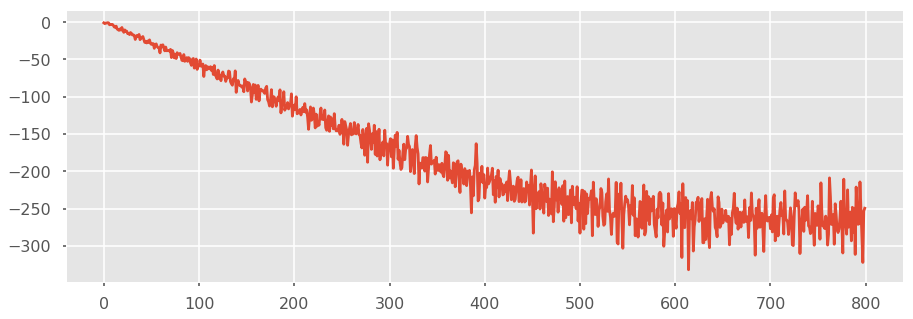

In [35]:
loss = train_poisson.v('loss')
plt.figure(figsize=(15, 5))
plt.plot(loss)
plt.show()

Create test pipeline and make predictions

In [36]:
test_poisson = (poisson_dset.test.p
                .load(src=(poisson_x, poisson_y))
                .import_model('poisson', train_poisson)
                .init_variable('predictions', [])
                .predict_model('poisson', 
                               fetches='exp',
                               features= B('features'),
                               targets=B('labels'),
                               save_to=V('predictions', mode='a'))
                .run(BATCH_SIZE, shuffle=True, n_epochs=1))

Measure the quality

In [37]:
pred = np.array(test_poisson.get_variable('predictions')).reshape(-1, 1)
target = np.array(poisson_y[poisson_dset.test.indices])

true_var = np.mean((target - np.mean(target))**2)
predict_var = np.mean((pred - np.mean(pred))**2)

error = np.mean(np.abs(pred - target)) / np.mean(target) * 100
print('Average error: {}%'.format(round(error, 3)), 'Variance ratio: %.3f' % (predict_var / true_var))

Average error: 66.16% Variance ratio: 0.830


## Conclusion
* No matter what you want to train and what data you want to use for it, pipeline always looks the same.
* It takes time to train an accurate model.
* Now you know how to use `batchflow` and specifically how to:
    * create pipelines for train and test models
    * train linear regression with multi-dimensional data
    * train logistic regression (with another type of data - two-dimensions clouds of dots)
    * create your own loss function and train poisson regression.

## What's next?
You might hone your new skills by:
* creating a multi-class regression model;
* adding aditional features to the model in order to improve the quality.

You might also want to dig deeper into [batch operations](./02_batch_operations.ipynb).

Or choose another topic from [the table of contents](./00_content.ipynb).